In [1]:
# Do not remove stop words
# LTSM + Dense + Dense
# No embeddings (50 dims)
# Val: 0.76 after 13 epochs


# Remove stop words
# LSTM + Dense + Dense
# Embeddings (ruscorpora_upos_cbow_300_20_2019 #180)
# acc: 0.9433 - val_acc: 0.8199 after 10 epochs

# Remove stop words
# LSTM + Dense + Dense
# Embeddings (ruwikiruscorpora_upos_skipgram_300_2_2019 #182)
# acc: 0.9413 - val_loss: 1.0506 - val_acc: 0.8571

# Embeddings (tayga_none_fasttextcbow_300_10_2019 #187)
# loss: 0.2405 - acc: 0.9440 - val_loss: 1.7026 - val_acc: 0.7391


import numpy as np
import tensorflow as tf
import random 
import json
import random
import urlextract
import re
import math
import matplotlib.pyplot as plt


from collections import defaultdict
from tensorflow.keras import Model, Input, Sequential, initializers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, Layer, InputSpec, Dense, TimeDistributed, Dropout, Bidirectional, Lambda, Add, Flatten, Activation
from tensorflow.keras.regularizers import L1L2
from gensim.models.keyedvectors import FastTextKeyedVectors
from nltk.tokenize import sent_tokenize, word_tokenize, sent_tokenize
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords
from collections import Counter, defaultdict
from allennlp.commands.elmo import ElmoEmbedder

In [23]:
# load data from doccano
raw_data = []
with open("C:\\Projects\\Research\\Events\\notebooks\\file.json", "r+", encoding="utf-8") as f:
    for line in f:
        raw_data.append(json.loads(line.strip()))

data = [(d['text'], [a['label'] for a in d['annotations']]) for d in raw_data]
data = [d for d in data if len(d[1]) > 0]

labels = sorted(list(set([item for sublist in [d[1] for d in data] for item in sublist])))
label_names = [
    "Вечеринка", "Выставка", "Конкурс", "Конференция", "Концерт", "Лекция", "Спектакль", "Фестиваль", "Шоу", 
    "Встреча", "Презентация", "Прием заявок", "Просмотр", "Экскурсия", "Ярмарка", "Игра", "Стендап",  
    "Дегустация", "Спортивное мероприятие", "Концертная программа", "Курсы", "Обсуждение", "Занятие"]


data = [(d[0], [label_names[labels.index(l)] for l in d[1]]) for d in data]
print(len(label_names) == len(labels))
print(len(data))


True
2207


In [26]:
# save data
with open("C:\\Projects\\Research\\Events\\data\\training\\type_data.json", "w+", encoding='utf-8') as f:
    json.dump(data, f, ensure_ascii=False, indent=4)

In [2]:
# Load preprocessed data for training
with open("C:\\Projects\\Research\\Events\\data\\training\\type_data.json", "r+", encoding='utf-8') as f:
    data = json.load(f)
    
label_mapping = {
    "Встреча": ["training"],
    "Курсы": ["training"],
    "Презентация": ["lecture"],
    "Прием заявок": [],
    "Конференция": ["lecture"],
    "Обсуждение": ["training"],
    'Вечеринка': ["party"],
    'Выставка': ['exhibition'],
    'Занятие': ['training'],
    'Игра': ['game'],
    'Концерт': ['concert'],
    'Концертная программа': ['concert_programm'],
    'Лекция': ['lecture'],
    'Просмотр': ['view'],
    'Спектакль': ['theatre'],
    'Спортивное мероприятие': ['sport'],
    'Стендап': ['standup'],
    'Фестиваль': ['festival'],
    'Шоу': ['show'],
    'Экскурсия': ['tour'],
    'Ярмарка': ['market'],
    'Дегустация': ['food'],
    'Конкурс': ['compete']
}

for i in range(len(data)):
    event = data[i]
    if len(event[1]) == 0:
        continue
    mapped_events = []
    for j in range(len(event[1])):
        label = event[1][j]
        if label in label_mapping:
            mapped_events.extend(label_mapping[label])
        else:
            mapped_events.append(label)
            
    event[1] = list(set(mapped_events))

In [11]:
labels = sorted(list(set([item for sublist in [d[1] for d in data] for item in sublist])))
labels

['compete',
 'concert',
 'concert_programm',
 'exhibition',
 'festival',
 'food',
 'free',
 'game',
 'lecture',
 'market',
 'online',
 'open air',
 'party',
 'show',
 'sport',
 'standup',
 'theatre',
 'tour',
 'training',
 'view']

In [12]:
labels_counts = {}
for text, text_labels in data:
    for label in text_labels:
        if label not in labels_counts:
            labels_counts[label] = 0
        labels_counts[label] += 1
labels_counts

{'concert_programm': 501,
 'theatre': 553,
 'view': 501,
 'training': 506,
 'concert': 541,
 'show': 514,
 'standup': 450,
 'lecture': 504,
 'game': 500,
 'festival': 550,
 'exhibition': 520,
 'tour': 510,
 'compete': 140,
 'food': 110,
 'party': 521,
 'sport': 503,
 'market': 506,
 'free': 1387,
 'open air': 197,
 'online': 35}

In [7]:
# Augment classes
with open("augment_events.json", "r+", encoding='utf-8') as f:
    augment_events = json.load(f)
    random.shuffle(augment_events)

In [8]:
class_length = 500
for event in augment_events:
    event_types = event['types']
    for event_type in event_types:
        if event_type not in labels_counts:
            continue
        if labels_counts[event_type] < class_length:
            text = event['title'] + event['description']
            data.append((text, event_types))
            for event_type in event_types:
                if event_type not in labels_counts:
                    continue
                labels_counts[event_type] += 1
            break

In [9]:
data[-1]

('Задаётесь вопросами, куда пригласить возлюблённую или какой подарок сделать подруге на 8 Марта? Приходите в NewPlaceMoscow! Стендап-комики порадуют выступлениями, а организаторы — сюрпризами. Можно не сомневаться: участники популярных телепроектов сделают вечер ярким.\n\nв Instagram https://www.instagram.com/newplacekafe/ .\n',
 ['standup'])

In [13]:
# save created dataset as doccano doc
with open("event_for_training.jsonl", "w+", encoding='utf-8') as f:
    random.shuffle(data)
    for text, labels in data:
        if len(text) < 10:
            continue
        if len(labels) == 0:
            labels = ["-"]
        j = json.dumps({"text": text.strip(), "labels": list(set(labels))}, ensure_ascii=False)
        f.write(j + "\n")

In [ ]:
class TextPreprocessor:
    def __init__(self):
        self.stemmer = PorterStemmer()
        self.url_extractor = urlextract.URLExtract()
        self.tag_regex = re.compile(r"<[^>]*>")
        self.email_regex = re.compile(r"[^\s]+@[^\s]+")
        self.number_regex = re.compile(r'\d+(?:\.\d*(?:[eE]\d+))?')
        self.dollar_regex = re.compile(r"[$]+")
        self.spaces_regex = re.compile(r"\s+")
        self.special_chars = [
            "<", "[", "]", "`", "^", ">", "+", "?", "!", "'", ".", ",", ":",
            "*", "%", "#", "_", "=", "-", "&", '/', '\\', '(', ')', ";", "\"", "«", "»", "|", "•", "—", "–", "●", "►", "\n",
            "@"
        ]
        self.stop_words = set(stopwords.words('russian'))
        
    def preprocess_text(self, text):
        text = text.lower()
        text = text.replace('\\xa', ' ')
        text = self.remove_html_tags(text)
        text = self.replace_urls(text)
        text = self.replace_emails(text)
        text = self.replace_numbers(text)
        text = self.replace_dollar_signs(text)
        return text

    def preprocess_to_sentences(self, text):
        text = self.preprocess_text(text)
        sentences = self.split_by_sentences(text)
        sentences = self.remove_special_characters(sentences)
        sentences = list(self.split_by_tokens(sentences))
        sentences = list(self.remove_stop_words(sentences))
        return sentences
    
    def preprocess_to_tokens(self, text):
        text = self.preprocess_text(text)
        sentences = self.remove_special_characters([text])
        sentences = list(self.split_by_tokens(sentences))
        sentences = list(self.remove_stop_words(sentences))
        return sentences[0]
    
    def split_by_tokens(self, sentences):
        for sentence in sentences:
            yield [morph.parse(t.lower().strip())[0].normal_form for t in word_tokenize(sentence)]
    
    def split_by_sentences(self, text):
        lines = text.split('\n')
        sentences = []
        for line in lines:
            sentences.extend(sent_tokenize(line))
        return sentences

    def remove_html_tags(self, text):
        text = self.tag_regex.sub(" ", text).split(" ")
        text = filter(len, text)
        text = ' '.join(text)
        return text

    def replace_urls(self, text):
        urls = list(set(self.url_extractor.find_urls(text)))
        urls.sort(key=lambda u: len(u), reverse=True)
        for url in urls:
            text = text.replace(url, " httpaddr ")
        return text

    def replace_emails(self, text):
        return self.email_regex.sub(" emailaddr ", text)
    
    def replace_numbers(self, text):
        return self.number_regex.sub(" number ", text)

    def replace_dollar_signs(self, text):
        return self.dollar_regex.sub(" dollar ", text)

    def remove_special_characters(self, sentences):
        for i in range(len(sentences)):
            for char in self.special_chars:
                sentences[i] = sentences[i].replace(str(char), " ")
        return sentences
    
    def remove_stop_words(self, sentences):
        for tokens in sentences:
            yield [token for token in tokens if token not in self.stop_words]

preprocessor = TextPreprocessor()
import pymorphy2
morph = pymorphy2.MorphAnalyzer()

def tokenize(text):
    return preprocessor.preprocess_to_tokens(text)

In [92]:
data = [(tokenize(d[0]), d[1]) for d in data]

In [93]:
# Load embeddings

def load_embeddings(filename):
    vocab = []
    idx2word = ["<PAD>", "<UNK>"]
    word2idx = defaultdict(lambda: 1)
    word2idx["<PAD>"] = 0
    word2idx["<UNK>"] = 1
    embeddings = []
    
    with open(filename, "r+", encoding="utf-8") as f:
        vocab_size, embedding_dim = f.readline().strip().split(" ")
        embedding_dim = int(embedding_dim)
        embeddings = [np.zeros(embedding_dim), np.random.rand(embedding_dim)]
        for line in f:
            word_pos, *vector = line.strip().split(" ")
            word, pos = word_pos.split("_")
            vector = np.array([float(v) for v in vector])
            idx2word.append(word)
            word2idx[word] = len(idx2word) - 1
            embeddings.append(vector)

    embeddings = np.array(embeddings)
    return idx2word, word2idx, embeddings


idx2word, word2idx, embeddings = load_embeddings("static embeddings\\182\\model.txt")

In [ ]:
# custom vocab
vocab = sorted(list(set([item for sublist in [d[0] for d in data] for item in sublist])))

special_tokens = ["<PAD>", "<UNK>"]
idx2word = special_tokens
word2idx = defaultdict(lambda: 1)
word2idx["<PAD>"] = 0
word2idx["<UNK>"] = 1

for word in vocab:
    idx2word.append(word)
    word2idx[word] = len(idx2word) - 1

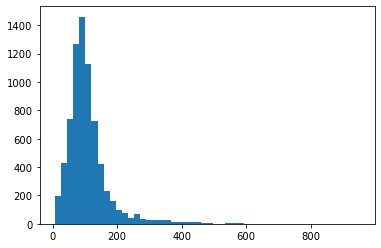

In [94]:
# analyze lengths

lengths = [len(d[0]) for d in data]
plt.hist(lengths, bins = 50)
plt.show()

In [99]:
max_length = 550

def pad_data(tokens):
    idxs = [word2idx[word] for word in tokens]
    pad_idx = word2idx["<PAD>"]
    if len(idxs) < max_length:
        idxs.extend([pad_idx] * (max_length - len(idxs)))
    else:
        return np.array(idxs[:max_length])
    return np.array(idxs)

def pad_data_fasttext(tokens, model):
    vectors = [model[word] for word in tokens]
    dim = len(vectors[0])
    pad_vector = np.zeros(dim)
    if len(vectors) < max_length:
        vectors.extend([pad_vector] * (max_length - len(vectors)))
    else:
        return np.array(vectors[:max_length])
    return np.array(vectors)

def pad_data_elmo(sentences, model):
    vectors = []
    for tokens in sentences: 
        vectors.extend(elmo.embed_sentence(tokens))
    vectors = np.concatenate((vectors[0], vectors[1], vectors[2]), axis=1)
    count, dim = vectors.shape
    pad_vector = np.zeros(dim)
    vectors = list(vectors)
    if len(vectors) < max_length:
        vectors.extend([pad_vector] * (max_length - len(vectors)))
    else:
        return np.array(vectors[:max_length])
    return np.array(vectors)

def labels_to_one_hot(text_labels):
    one_hot = np.zeros(len(labels))
    for label in text_labels:
        one_hot[labels.index(label)] = 1
    return one_hot

In [103]:
x_train_data = []
y_train_data = []

train_data = []

for tokens, token_labels in data:
    train_data.append((pad_data(tokens), labels_to_one_hot(token_labels)))

random.shuffle(train_data)

val_data = train_data[:289]
train_data = train_data[289:]

x_train_data = np.array([d[0] for d in train_data])
y_train_data = np.array([d[1] for d in train_data])
                      
x_val_data = np.array([d[0] for d in val_data])
y_val_data = np.array([d[1] for d in val_data])

In [104]:
x_train_data.shape

(7000, 550)

In [107]:
# fasttext

model = FastTextKeyedVectors.load("static embeddings\\187\\model.model")

x_train_data = []
y_train_data = []

train_data = []

for tokens, token_labels in data:
    train_data.append((pad_data_fasttext(tokens, model), labels_to_one_hot(token_labels)))

random.shuffle(train_data)

val_data = train_data[:207]
train_data = train_data[207:]

x_train_data = np.array([d[0] for d in train_data])
y_train_data = np.array([d[1] for d in train_data])
                      
x_val_data = np.array([d[0] for d in val_data])
y_val_data = np.array([d[1] for d in val_data])

In [ ]:
# elmo
# long to execute

elmo = ElmoEmbedder(options_file='context embeddings\\199\\options.json', weight_file='context embeddings\\199\\model.hdf5')

x_train_data = []
y_train_data = []

train_data = []

i = 0
for tokens, token_labels in data:
    train_data.append((pad_data_elmo(tokens, elmo), labels_to_one_hot(token_labels)))
    i += 1
    if i % 10 == 0:
        print(i)

random.shuffle(train_data)

val_data = train_data[:161]
train_data = train_data[161:]

x_train_data = np.array([d[0] for d in train_data])
y_train_data = np.array([d[1] for d in train_data])
                      
x_val_data = np.array([d[0] for d in val_data])
y_val_data = np.array([d[1] for d in val_data])

In [105]:
# Embeddings

n_words, embedding_dim = embeddings.shape
train_len, length = x_train_data.shape

model = Sequential([
    Embedding(input_dim=n_words, output_dim=embedding_dim, 
              weights=[embeddings], trainable=False, mask_zero=True, 
              input_shape=(length, )),
    Bidirectional(LSTM(128)),
    Dropout(0.1),
    Dense(512),
    Dropout(0.1),
    Dense(256),
    Dropout(0.1),
    Dense(128),
    Dense(len(labels), activation='sigmoid')
])

model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      (None, 550, 300)          74694000  
_________________________________________________________________
bidirectional_2 (Bidirection (None, 256)               439296    
_________________________________________________________________
dropout_4 (Dropout)          (None, 256)               0         
_________________________________________________________________
dense_6 (Dense)              (None, 512)               131584    
_________________________________________________________________
dropout_5 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_7 (Dense)              (None, 256)               131328    
_________________________________________________________________
dropout_6 (Dropout)          (None, 256)              

In [106]:
history = model.fit(x_train_data, y_train_data, batch_size=32, epochs=10, verbose=1, validation_data=(x_val_data, y_val_data))

Train on 7000 samples, validate on 289 samples
Epoch 1/10
7000/7000 [==============================] - 1679s 240ms/sample - loss: 2.6767 - acc: 0.3867 - val_loss: 1.9279 - val_acc: 0.5675
Epoch 2/10
7000/7000 [==============================] - 1436s 205ms/sample - loss: 1.8377 - acc: 0.5957 - val_loss: 1.7413 - val_acc: 0.6159
Epoch 3/10
7000/7000 [==============================] - 1436s 205ms/sample - loss: 1.5531 - acc: 0.6520 - val_loss: 1.8596 - val_acc: 0.6194
Epoch 4/10
7000/7000 [==============================] - 1431s 204ms/sample - loss: 1.3247 - acc: 0.6950 - val_loss: 1.8801 - val_acc: 0.6540
Epoch 5/10
7000/7000 [==============================] - 1434s 205ms/sample - loss: 1.1854 - acc: 0.7209 - val_loss: 1.6692 - val_acc: 0.7024
Epoch 6/10
7000/7000 [==============================] - 1446s 207ms/sample - loss: 1.0383 - acc: 0.7523 - val_loss: 1.7811 - val_acc: 0.6505
Epoch 7/10
7000/7000 [==============================] - 1432s 205ms/sample - loss: 0.9363 - acc: 0.7711 - v

In [108]:
# Fasttext (ELMO) Embeddings

_, length, dim = x_train_data.shape

model = Sequential([
    Bidirectional(LSTM(64), input_shape=(length, dim, )),
    Dropout(0.1),
    Dense(512),
    Dense(256),
    Dense(len(labels), activation='sigmoid')
])

batch_size = 32
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_3 (Bidirection (None, 128)               186880    
_________________________________________________________________
dropout_7 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 512)               66048     
_________________________________________________________________
dense_11 (Dense)             (None, 256)               131328    
_________________________________________________________________
dense_12 (Dense)             (None, 20)                5140      
Total params: 389,396
Trainable params: 389,396
Non-trainable params: 0
_________________________________________________________________


In [110]:
history = model.fit(x_train_data, y_train_data, batch_size=batch_size, epochs=10, verbose=1, validation_data=(x_val_data, y_val_data))

Train on 7082 samples, validate on 207 samples
Epoch 1/10
7082/7082 [==============================] - 583s 82ms/sample - loss: 2.9272 - acc: 0.3328 - val_loss: 2.2936 - val_acc: 0.4879
Epoch 2/10
7082/7082 [==============================] - 692s 98ms/sample - loss: 2.1022 - acc: 0.5345 - val_loss: 2.0483 - val_acc: 0.5556
Epoch 3/10
7082/7082 [==============================] - 685s 97ms/sample - loss: 1.7738 - acc: 0.6062 - val_loss: 1.9868 - val_acc: 0.5700
Epoch 4/10
7082/7082 [==============================] - 500s 71ms/sample - loss: 1.5497 - acc: 0.6361 - val_loss: 2.0607 - val_acc: 0.5604
Epoch 5/10
7082/7082 [==============================] - 456s 64ms/sample - loss: 1.4131 - acc: 0.6661 - val_loss: 1.9058 - val_acc: 0.5894
Epoch 6/10
7082/7082 [==============================] - 458s 65ms/sample - loss: 1.2858 - acc: 0.6994 - val_loss: 2.0057 - val_acc: 0.5700
Epoch 7/10
7082/7082 [==============================] - 458s 65ms/sample - loss: 1.2045 - acc: 0.7101 - val_loss: 2.011

In [ ]:
y_val_pred = model.predict([x_val_data, i_val_data])

In [ ]:
np.argmax(y_val_pred[15])

In [ ]:
import tensorflow as tf
from tensorflow.keras import Model, Input, Sequential, initializers
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import LSTM, Embedding, Layer, InputSpec, Dense, TimeDistributed, Dropout, Bidirectional, Lambda, Add, Flatten, Activation
from tensorflow.keras.regularizers import L1L2


n_words = len(idx2word)
embedding_dim = 50
batch_size = 32

tokens_input = Input(shape=(max_length,))

embedding = Embedding(input_dim=n_words, output_dim=embedding_dim)(tokens_input)
features = Bidirectional(LSTM(128))(embedding)
features = Dropout(0.1)(features)
dense = Dense(512)(features)
dense = Dense(256)(features)
output = Dense(len(labels), activation='sigmoid')(features)

model = Model(inputs=[tokens_input], outputs=[output])
model.compile('adam', 'categorical_crossentropy', metrics=['accuracy'])
model.summary()

In [ ]:
# 13 epoch - max val value
model.fit([x_train_data], y_train_data, batch_size=batch_size, epochs=15, verbose=1, validation_data=([x_val_data], y_val_data))

In [ ]:
history2 = model.fit([x_train_data], y_train_data, batch_size=batch_size, epochs=5, verbose=1, validation_data=([x_val_data], y_val_data))